In [2]:
# Importação de pacotes básicos necessários para a análise
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_predict
from sklearn.metrics import classification_report, accuracy_score, r2_score, roc_curve, auc, confusion_matrix, precision_recall_curve, roc_auc_score, average_precision_score, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from feature_engine.selection import SmartCorrelatedSelection
from feature_engine.selection import MRMR
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.base import clone
from sklearn.feature_selection import mutual_info_classif
from scipy.stats import pearsonr
from tqdm import tqdm
from joblib import Parallel, delayed
from sklearn.neighbors import KNeighborsClassifier
from collections import defaultdict

In [3]:
#Importação e inspeção dos dados espectrométricos.
#Os dados foram aleatorizados e divididos em 5 folds para validação cruzada esse é o fold 1
df=pd.read_excel('C:/Users/raissa.alves/OneDrive/Mestrado/Artigo 1/viagra.xlsx')
df.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x653,x654,x655,x656,x657,x658,x659,x660,x661,y
0,0.076611,0.076999,0.077252,0.077173,0.076725,0.078280,0.079436,0.078157,0.079191,0.081329,...,0.011600,0.009684,0.010075,0.011222,0.012652,0.013543,0.011558,0.011248,0.012533,1
1,0.144300,0.143482,0.143127,0.143085,0.143878,0.144884,0.146375,0.148714,0.150978,0.153815,...,0.015382,0.015612,0.015633,0.016043,0.015417,0.014056,0.014065,0.015187,0.015242,1
2,0.142775,0.143303,0.144032,0.143513,0.142435,0.144080,0.147601,0.149089,0.150841,0.153784,...,0.015288,0.015554,0.015320,0.015522,0.014896,0.014057,0.014397,0.015305,0.014908,1
3,0.099668,0.099394,0.099942,0.101049,0.101606,0.102474,0.104298,0.104109,0.104940,0.107257,...,0.015128,0.012936,0.013664,0.015122,0.016901,0.018029,0.015869,0.015787,0.017194,1
4,0.153480,0.153954,0.155493,0.156135,0.156497,0.156849,0.158756,0.160535,0.161770,0.165062,...,0.010665,0.011046,0.010701,0.011083,0.010609,0.009467,0.009332,0.010254,0.010268,1


In [6]:
# Separar as variáveis independentes (X) e a variável dependente (y)
X = df.iloc[:, :-1]  # Seleciona todas as colunas, exceto a última (variáveis independentes)
y = df.iloc[:, -1].values  # Seleciona a última coluna como um array NumPy (variável dependente)

In [7]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
        
# Dividindo o conjunto de treino em treino e validação
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=42)

In [17]:
#Ranqueamento de variáveis com MRMR

def full_mrmr_ranking(X_train, y_train, n_jobs=-1):
    """
    MRMR otimizado que gera ranking completo com todas as features (661 no seu caso).
    
    Args:
        X_train (pd.DataFrame): DataFrame com todas as 661 features.
        y_train (pd.Series): Classes (0 ou 1).
        n_jobs (int): Número de núcleos para paralelização (-1 = todos).
    
    Returns:
        pd.DataFrame: Ranking completo com todas as 661 features ordenadas por MRMR_Score.
    """
    features = X_train.columns.tolist()
    K = len(features)  # Garante que todas as features serão avaliadas (661)
    selected = []
    scores = {}
    
    # 1. Pré-calcular matriz de correlação absoluta (otimização crítica)
    print("Pré-calculando matriz de correlação...")
    corr_matrix = X_train.corr().abs().values
    
    # 2. Calcular relevância (mutual information) para todas as features
    print("Calculando relevância...")
    mi = mutual_info_classif(X_train, y_train, discrete_features=False, random_state=42)
    relevance = {f: mi[i] for i, f in enumerate(features)}
    
    # 3. MRMR iterativo (paralelizado e otimizado)
    print("Processando ranking MRMR completo (661 features)...")
    for _ in tqdm(range(K)):
        remaining = [f for f in features if f not in selected]
        
        # Função para cálculo paralelizado do score MRMR
        def calculate_score(f):
            idx_f = X_train.columns.get_loc(f)
            rel = relevance[f]
            
            if selected:
                idx_selected = [X_train.columns.get_loc(s) for s in selected]
                redundancy = np.mean(corr_matrix[idx_f, idx_selected])
            else:
                redundancy = 0
            
            return rel - redundancy
        
        # Paralelização do cálculo (principal ganho de performance)
        feature_scores = Parallel(n_jobs=n_jobs)(
            delayed(calculate_score)(f) for f in remaining
        )
        
        # Encontrar a melhor feature nesta iteração
        best_idx = np.argmax(feature_scores)
        best_feature = remaining[best_idx]
        best_score = feature_scores[best_idx]
        
        scores[best_feature] = best_score
        selected.append(best_feature)
    
    # 4. Gerar DataFrame ordenado com todas as 661 features
    results = pd.DataFrame({
        'Feature': selected,
        'MRMR_Score': [scores[f] for f in selected],
        'Relevance': [relevance[f] for f in selected]
    })
    
    return results

# Uso:
ranked_features= full_mrmr_ranking(X_train, y_train)

# Para salvar como Excel (requer openpyxl ou xlsxwriter)
ranked_features.to_excel(r'C:/Users/raissa.alves/OneDrive/Mestrado/Artigo 1/mrmr_results.xlsx', index=False)


Pré-calculando matriz de correlação...
Calculando relevância...
Processando ranking MRMR completo (661 features)...


100%|██████████| 661/661 [05:56<00:00,  1.85it/s]


In [18]:
# Visualizar ranking
print("\nTop 661 Comprimentos de Onda:")
print(ranked_features.head(661).to_string(index=False))


Top 661 Comprimentos de Onda:
Feature  MRMR_Score  Relevance
   x468    0.409257   0.409257
   x308    0.079636   0.327608
   x648   -0.095372   0.044546
   x416    0.012548   0.396597
   x301   -0.093283   0.340195
   x415   -0.087026   0.382094
   x309   -0.151733   0.313378
   x417   -0.120879   0.380812
   x186   -0.178701   0.324942
   x320   -0.138187   0.300887
   x402   -0.169931   0.397912
   x300   -0.164835   0.330550
   x477   -0.185652   0.395513
   x658   -0.183081   0.065978
   x307   -0.169024   0.317676
   x403   -0.160015   0.383261
   x319   -0.187066   0.301769
   x433   -0.167631   0.359625
   x476   -0.196122   0.389216
   x302   -0.182800   0.332918
   x434   -0.199895   0.358119
   x303   -0.190756   0.334383
   x179   -0.201416   0.318758
   x304   -0.198738   0.329668
   x432   -0.202169   0.353806
   x299   -0.210979   0.311423
   x418   -0.207812   0.358069
   x310   -0.218072   0.296573
   x395   -0.210530   0.372316
   x187   -0.223883   0.298788
   x296 


Avaliando SVM

Fold 1/10:
Features:   1 | Val Acc: 0.9231
Features:   2 | Val Acc: 1.0000
--> Acurácia perfeita (1.0) alcançada com 2 features. Parando avaliação para este fold.

Fold 2/10:
Features:   1 | Val Acc: 0.9231
Features:   2 | Val Acc: 0.8462
Features:   3 | Val Acc: 0.9231
Features:   4 | Val Acc: 0.9231
Features:   5 | Val Acc: 0.9231
Features:   6 | Val Acc: 0.9231
Features:   7 | Val Acc: 0.9231
Features:   8 | Val Acc: 0.9231
Features:   9 | Val Acc: 0.9231
Features:  10 | Val Acc: 0.9231
Features:  11 | Val Acc: 0.9231
Features:  12 | Val Acc: 0.9231
Features:  13 | Val Acc: 0.9231
Features:  14 | Val Acc: 0.9231
Features:  15 | Val Acc: 0.9231
Features:  16 | Val Acc: 0.9231
Features:  17 | Val Acc: 0.9231
Features:  18 | Val Acc: 0.9231
Features:  19 | Val Acc: 0.9231
Features:  20 | Val Acc: 0.9231
Features:  21 | Val Acc: 0.9231
Features:  22 | Val Acc: 0.9231
Features:  23 | Val Acc: 0.9231
Features:  24 | Val Acc: 0.9231
Features:  25 | Val Acc: 0.9231
Features:

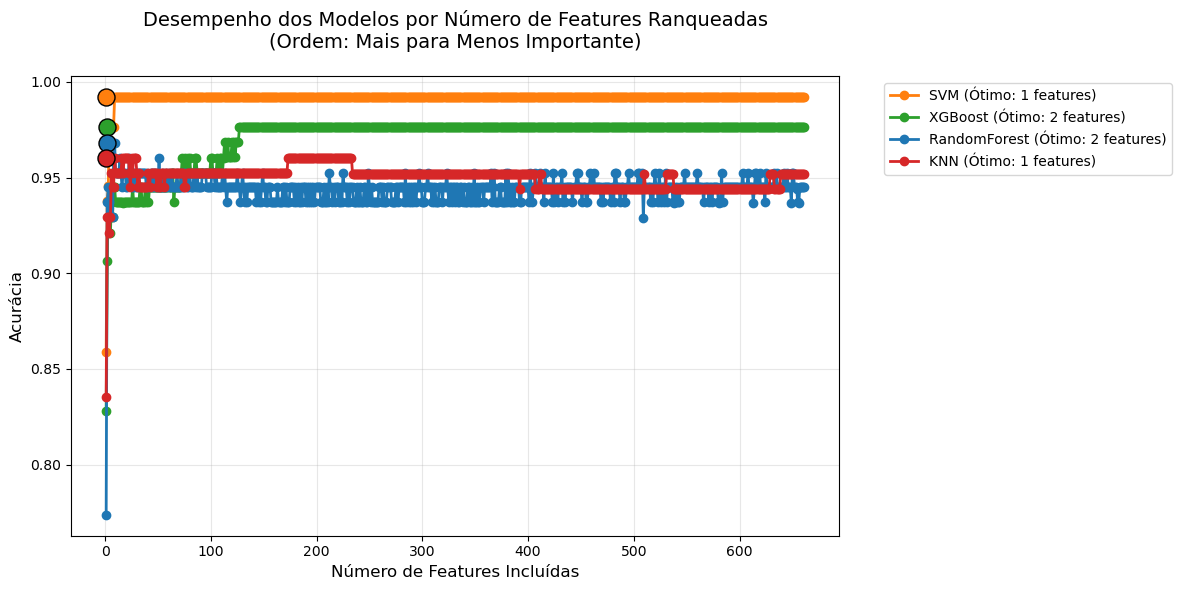

<Figure size 1200x600 with 0 Axes>

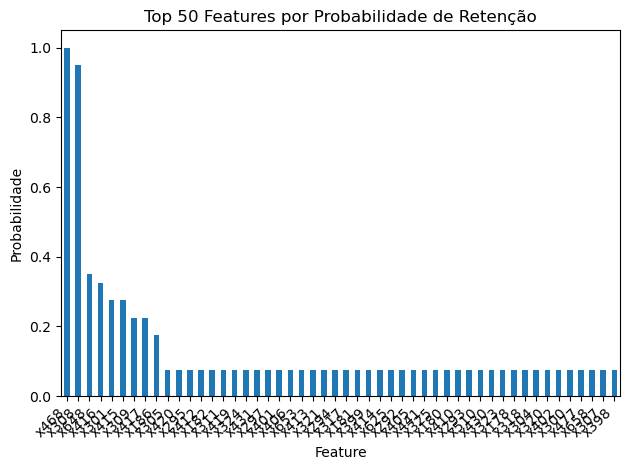

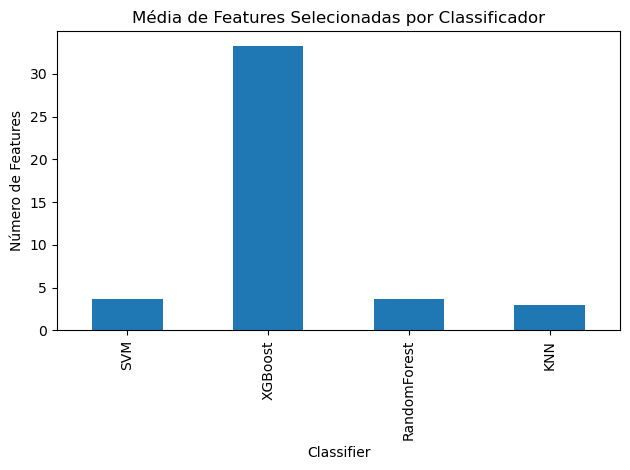


Resultados Consolidados (10-folds):
      Modelo                                                                                   Melhores Parâmetros  Acurácia Média  Acurácia Std  Nº Features Médio  Nº Features Std  Folds com Acurácia 1.0  Folds com Parada Antecipada
         SVM                                                                            {'C': 10, 'kernel': 'rbf'}        0.992308      0.023077                  3         2.794638                       9                            9
     XGBoost {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 50, 'subsample': 1.0}        0.976282      0.049988                 33        48.047997                       8                            8
RandomForest                                       {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}        0.967949      0.039307                  3         2.685144                       6                            6
         KNN               

In [19]:

def plot_ranked_features_performance(performance_data: dict[str, dict[str, list[float] | list[int] | int | str]]):
    """
    Gera gráfico comparativo de desempenho por número de features ranqueadas
    """
    plt.figure(figsize=(12, 6))
    colors = {
        'SVM': '#ff7f0e',
        'XGBoost': '#2ca02c',
        'RandomForest': '#1f77b4',
        'KNN': '#d62728'
    }
    
    for model_name, data in performance_data.items():
        plt.plot(data['feature_counts'], data['accuracies'],
                'o-', color=data['color'],
                markersize=6, linewidth=2,
                label=f"{model_name} (Ótimo: {data['best_num_features']} features)")
        plt.scatter(data['best_num_features'], np.max(data['accuracies']),
                   s=150, color=data['color'], edgecolor='black', zorder=5)
    
    plt.title('Desempenho dos Modelos por Número de Features Ranqueadas\n(Ordem: Mais para Menos Importante)',
             fontsize=14, pad=20)
    plt.xlabel('Número de Features Incluídas', fontsize=12)
    plt.ylabel('Acurácia', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# 1. Configuração inicial
# Supondo que ranked_features já está definido como um DataFrame com coluna 'Feature'
ranked_features = ranked_features['Feature'].tolist()  # Converte para lista

# 2. Configuração dos modelos com parâmetros para GridSearch
classifiers = {
    'SVM': {
        'model': SVC(random_state=42, probability=True),
        'params': {
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'rbf']
        },
        'color': '#ff7f0e'
    },
    'XGBoost': {
        'model': XGBClassifier(random_state=42, n_jobs=-1, eval_metric='logloss'),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [3, 6, 9],
            'learning_rate': [0.01, 0.1, 0.2],
            'subsample': [0.8, 1.0],
            'colsample_bytree': [0.8, 1.0]
        },
        'color': '#2ca02c'
    },
    'RandomForest': {
        'model': RandomForestClassifier(random_state=42, n_jobs=-1),
        'params': {
            'n_estimators': [50, 100],
            'max_depth': [None, 10],
            'min_samples_split': [2, 5]
        },
        'color': '#1f77b4'
    },
    'KNN': {
        'model': KNeighborsClassifier(n_jobs=-1),
        'params': {
            'n_neighbors': [3, 5, 7],
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan']
        },
        'color': '#d62728'
    }
}

# 3. Estruturas para armazenamento de resultados
feature_retention = defaultdict(list)
classifier_stats = []
selected_features_per_fold = {clf_name: [] for clf_name in classifiers.keys()}
performance_data = {clf_name: {
    'accuracies': [],
    'feature_counts': [],
    'best_num_features': 0,
    'color': classifiers[clf_name]['color']
} for clf_name in classifiers.keys()}
final_results = []

# Configuração do KFold
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# 4. Avaliação progressiva com KFold e critério de parada por acurácia = 1.0
for clf_name, clf_config in classifiers.items():
    print(f'\n{"="*50}\nAvaliando {clf_name}\n{"="*50}')
    
    evaluation_points = list(np.linspace(1, len(ranked_features), 661, dtype=int))
    evaluation_points = sorted(list(set(evaluation_points + [len(ranked_features)])))
    
    fold_results = []
    all_accuracies = np.zeros((10, len(evaluation_points)))  # Matriz para armazenar todos os resultados
   
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train), 1):
        print(f'\nFold {fold}/10:')
        X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]
        
        best_fold_acc = 0
        best_fold_params = None
        best_fold_features = None
        early_stop = False
        
        for i, n in enumerate(evaluation_points):
            if early_stop:
                # Preenche os pontos restantes com o melhor valor encontrado
                all_accuracies[fold-1, i:] = best_fold_acc
                break
                
            current_features = ranked_features[:n]
            
            try:
                grid = GridSearchCV(
                    estimator=clone(clf_config['model']),
                    param_grid=clf_config['params'],
                    cv=5,
                    scoring='accuracy',
                    n_jobs=-1
                )
                grid.fit(X_fold_train[current_features], y_fold_train)
                
                val_acc = grid.best_estimator_.score(X_fold_val[current_features], y_fold_val)
                all_accuracies[fold-1, i] = val_acc
                
                if val_acc > best_fold_acc:
                    best_fold_acc = val_acc
                    best_fold_params = grid.best_params_
                    best_fold_features = current_features
                
                print(f'Features: {n:3d} | Val Acc: {val_acc:.4f}')
                
                # Critério de parada por acurácia = 1.0
                if val_acc == 1.0:
                    print(f"--> Acurácia perfeita (1.0) alcançada com {n} features. Parando avaliação para este fold.")
                    early_stop = True
                    # Preenche os pontos restantes com 1.0
                    all_accuracies[fold-1, i+1:] = 1.0
                    
            except Exception as e:
                print(f"Erro no {clf_name}, fold {fold}, features {n}: {str(e)}")
                all_accuracies[fold-1, i] = np.nan
                continue
        
        selected_features_per_fold[clf_name].append(best_fold_features)
        
        fold_results.append({
            'fold': fold,
            'best_acc': best_fold_acc,
            'best_n_features': len(best_fold_features) if best_fold_features else 0,
            'params': best_fold_params,
            'stopped_early': early_stop
        })
    
    # Calcular médias para plotagem (ignorando NaNs)
    mean_accuracies = np.nanmean(all_accuracies, axis=0)
    performance_data[clf_name]['accuracies'] = mean_accuracies
    performance_data[clf_name]['feature_counts'] = evaluation_points
    performance_data[clf_name]['best_num_features'] = int(np.min([f['best_n_features'] for f in fold_results]))
    
    # Calcular probabilidade de retenção por feature
    for feature in ranked_features:
        retention_count = sum(1 for fold_features in selected_features_per_fold[clf_name] 
                            if fold_features and feature in fold_features)
        feature_retention[feature].append(retention_count / 10)
    
    # Consolidar resultados entre folds
    avg_acc = np.mean([f['best_acc'] for f in fold_results])
    avg_features = int(np.mean([f['best_n_features'] for f in fold_results]))
    std_acc = np.std([f['best_acc'] for f in fold_results])
    std_features = np.std([f['best_n_features'] for f in fold_results])
    early_stops = sum(1 for f in fold_results if f['stopped_early'])
    
    # Resultados finais
    final_results.append({
        'Modelo': clf_name,
        'Melhores Parâmetros': best_fold_params,
        'Acurácia Média': avg_acc,
        'Acurácia Std': std_acc,
        'Nº Features Médio': avg_features,
        'Nº Features Std': std_features,
        'Folds com Acurácia 1.0': sum(1 for f in fold_results if f['best_acc'] == 1.0),
        'Folds com Parada Antecipada': early_stops
    })

# 5. Processamento dos resultados
retention_df = pd.DataFrame({
    'Feature': feature_retention.keys(),
    'Retention_Probability': [np.mean(probs) for probs in feature_retention.values()]
}).sort_values('Retention_Probability', ascending=False)

for clf_name in classifiers.keys():
    avg_features = np.mean([len(f) if f else 0 for f in selected_features_per_fold[clf_name]])
    classifier_stats.append({
        'Classifier': clf_name,
        'Avg_Features_Selected': avg_features,
        'Top_5_Features': ', '.join(retention_df.head(5)['Feature'].tolist())
    })

feature_selection_details = {}
for clf_name in classifiers.keys():
    all_features = [f for fold_features in selected_features_per_fold[clf_name] 
                   if fold_features for f in fold_features]
    if not all_features:
        feature_counts = pd.DataFrame({'Feature': [], 'Selection_Count': [], 'Selection_Rate': []})
    else:
        feature_counts = pd.Series(all_features).value_counts().reset_index()
        feature_counts.columns = ['Feature', 'Selection_Count']
        feature_counts['Selection_Rate'] = feature_counts['Selection_Count'] / 10
        feature_counts = feature_counts.sort_values('Selection_Rate', ascending=False)
    feature_selection_details[clf_name] = feature_counts

# 6. Geração de relatórios em Excel
with pd.ExcelWriter('feature_selection_report.xlsx') as writer:
    retention_df.to_excel(writer, sheet_name='Retention_Probability', index=False)
    pd.DataFrame(classifier_stats).to_excel(writer, sheet_name='Classifier_Stats', index=False)
    for clf_name in classifiers.keys():
        feature_selection_details[clf_name].to_excel(
            writer, 
            sheet_name=f'{clf_name[:30]} Features',
            index=False
        )
    pd.DataFrame(final_results).to_excel(writer, sheet_name='Summary_Results', index=False)

# 7. Visualizações
plot_ranked_features_performance(performance_data)

plt.figure(figsize=(12, 6))
# Ensure the Retention_Probability column is numeric
retention_df['Retention_Probability'] = pd.to_numeric(retention_df['Retention_Probability'], errors='coerce')

# Drop rows with NaN values in Retention_Probability to avoid plotting issues
retention_df_cleaned = retention_df.dropna(subset=['Retention_Probability'])

retention_df_cleaned.head(50).plot.bar(x='Feature', y='Retention_Probability', legend=False)
plt.title('Top 50 Features por Probabilidade de Retenção')
plt.ylabel('Probabilidade')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Gráfico de média de features por classificador
pd.DataFrame(classifier_stats).plot.bar(x='Classifier', y='Avg_Features_Selected', legend=False)
plt.title('Média de Features Selecionadas por Classificador')
plt.ylabel('Número de Features')
plt.tight_layout()
plt.show()

# 8. Resultados finais
results_comparison = pd.DataFrame(final_results)
print('\n' + '='*50)
print('Resultados Consolidados (10-folds):')
print('='*50)
print(results_comparison.sort_values('Acurácia Média', ascending=False).to_string(index=False))


Avaliando SVM com 1 melhores features


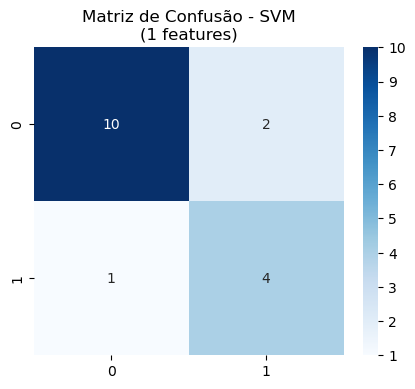


Relatório para SVM (top 1 features):
              precision    recall  f1-score   support

           0       0.91      0.83      0.87        12
           1       0.67      0.80      0.73         5

    accuracy                           0.82        17
   macro avg       0.79      0.82      0.80        17
weighted avg       0.84      0.82      0.83        17


Avaliando XGBoost com 2 melhores features


c:\users\raissa.alves\appdata\local\anaconda3\lib\site-packages\xgboost\training.py:183: UserWarning: [17:23:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "max_delpth" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


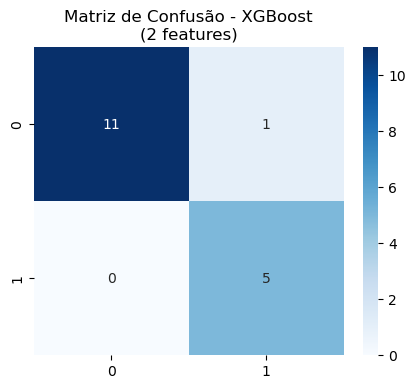


Relatório para XGBoost (top 2 features):
              precision    recall  f1-score   support

           0       1.00      0.92      0.96        12
           1       0.83      1.00      0.91         5

    accuracy                           0.94        17
   macro avg       0.92      0.96      0.93        17
weighted avg       0.95      0.94      0.94        17


Avaliando RandomForest com 2 melhores features


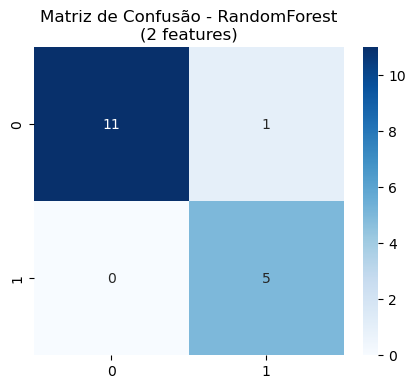


Relatório para RandomForest (top 2 features):
              precision    recall  f1-score   support

           0       1.00      0.92      0.96        12
           1       0.83      1.00      0.91         5

    accuracy                           0.94        17
   macro avg       0.92      0.96      0.93        17
weighted avg       0.95      0.94      0.94        17


Avaliando KNN com 1 melhores features


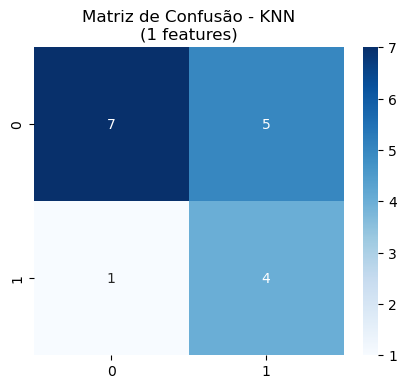


Relatório para KNN (top 1 features):
              precision    recall  f1-score   support

           0       0.88      0.58      0.70        12
           1       0.44      0.80      0.57         5

    accuracy                           0.65        17
   macro avg       0.66      0.69      0.64        17
weighted avg       0.75      0.65      0.66        17


Resultados Finais com Features Selecionadas:
         Modelo  Nº Features  Acurácia  Precisão  Recall  F1-Score   ROC-AUC
1       XGBoost            2  0.941176  0.833333     1.0  0.909091  1.000000
2  RandomForest            2  0.941176  0.833333     1.0  0.909091  0.983333
0           SVM            1  0.823529  0.666667     0.8  0.727273  0.966667
3           KNN            1  0.647059  0.444444     0.8  0.571429  0.783333


C:\Users\raissa.alves\AppData\Local\Temp\ipykernel_20332\440073629.py:93: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_comparison, x='Modelo', y='Acurácia', palette='viridis')


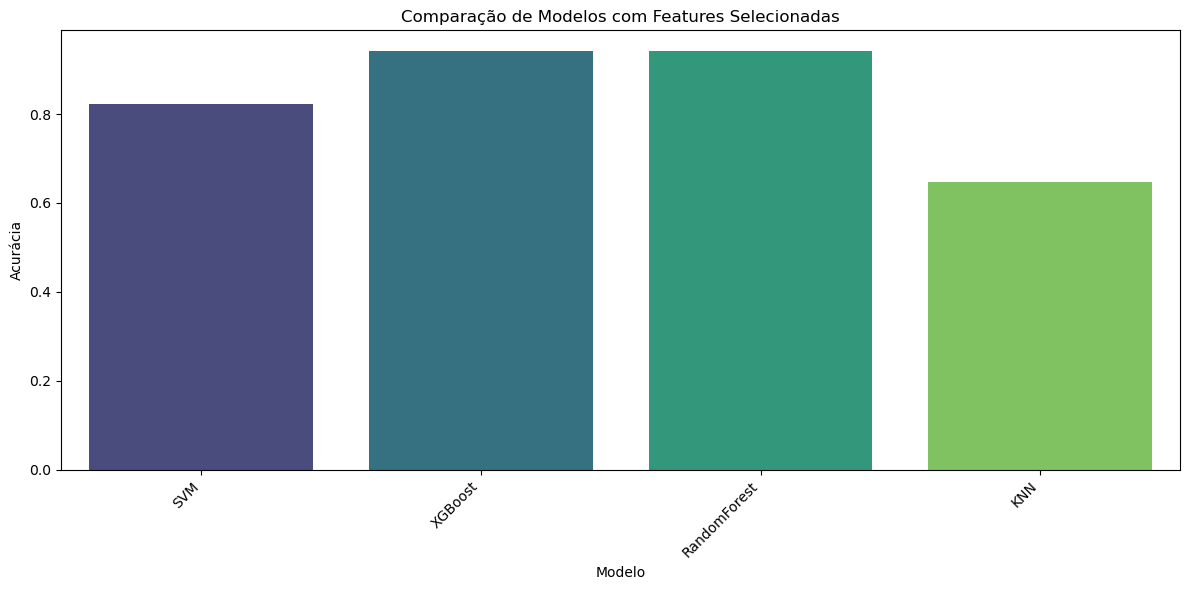

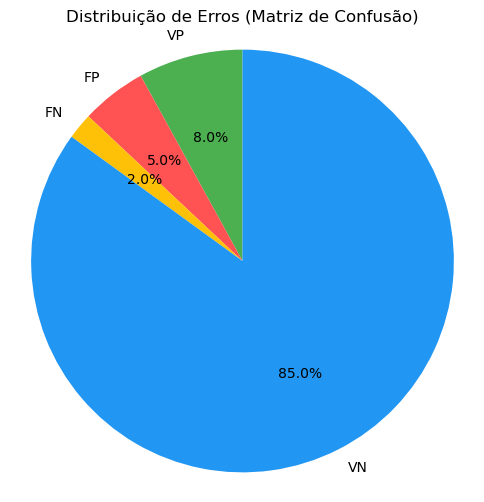

In [20]:
# Função para avaliação dos modelos com as melhores features
def evaluate_models_with_selected_features(X_train, X_test, y_train, y_test, results_comparison, ranked_features):
    """
    Avalia os modelos usando apenas as melhores features selecionadas
    
    Args:
        X_train, X_test: DataFrames com features
        y_train, y_test: Arrays com labels
        results_df: DataFrame com resultados dos modelos (contém 'Modelo' e 'Nº Features Ótimo')
    """
    
    # Dicionário para armazenar os modelos configurados
    models_config = {
        'SVM': {
            'model': SVC(random_state=42, C=10, kernel='rbf', probability=True),
            'num_features': 1
        },
        'XGBoost': {
            'model': XGBClassifier(random_state=42, colsample_bytree=1.0, learning_rate=0.1, max_delpth=6, n_estimators=50, subsample=1.0),
            'num_features': 2
        },
        'RandomForest': {
            'model': RandomForestClassifier(random_state=42, max_depth=None, n_estimators=50, min_samples_split=2),
            'num_features': 2
        },
        'KNN': {
            'model': KNeighborsClassifier(metric='manhattan', n_neighbors=3, weights='distance'),
            'num_features': 1
        }
    }
    
    # Extrair as features ranqueadas
    # Remove this line as ranked_features is now passed as an argument
    
    # Avaliação de cada modelo
    final_results = []
    
    for model_name, config in models_config.items():
        print(f"\n{'='*50}\nAvaliando {model_name} com {config['num_features']} melhores features\n{'='*50}")
        
        # Selecionar as melhores features para este modelo
        selected_features = ranked_features[:config['num_features']]
        
        # Verificar se as features existem nos dados
        available_features = [f for f in selected_features if f in X_train.columns]
        if len(available_features) < config['num_features']:
            print(f"Aviso: Apenas {len(available_features)} features disponíveis das {config['num_features']} esperadas")
        
        # Filtrar os dados
        X_train_filtered = X_train[available_features]
        X_test_filtered = X_test[available_features]
        
        # Clonar e treinar o modelo
        model = clone(config['model'])
        model.fit(X_train_filtered, y_train)
        
        # Avaliação
        y_pred = model.predict(X_test_filtered)
        y_proba = model.predict_proba(X_test_filtered)[:, 1] if hasattr(model, "predict_proba") else None
        
        # Métricas
        metrics = {
            'Modelo': model_name,
            'Nº Features': len(available_features),
            'Acurácia': accuracy_score(y_test, y_pred),
            'Precisão': precision_score(y_test, y_pred),
            'Recall': recall_score(y_test, y_pred),
            'F1-Score': f1_score(y_test, y_pred),
            'ROC-AUC': roc_auc_score(y_test, y_proba) if y_proba is not None else 'N/A'
        }
        final_results.append(metrics)
        
        # Matriz de confusão
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(5,4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Matriz de Confusão - {model_name}\n({len(available_features)} features)')
        plt.show()
        
        # Relatório de classificação
        print(f"\nRelatório para {model_name} (top {len(available_features)} features):")
        print(classification_report(y_test, y_pred))
    
    # Resultados comparativos
    results_comparison = pd.DataFrame(final_results)
    print("\n" + "="*50)
    print("Resultados Finais com Features Selecionadas:")
    print("="*50)
    print(results_comparison.sort_values('Acurácia', ascending=False))

    # Gráfico de comparação de desempenho
    plt.figure(figsize=(12,6))
    sns.barplot(data=results_comparison, x='Modelo', y='Acurácia', palette='viridis')
    plt.title('Comparação de Modelos com Features Selecionadas')  
    plt.ylabel('Acurácia')
    plt.xlabel('Modelo')
    plt.xticks(rotation=45, ha='right') 
    plt.tight_layout()
    plt.show()    
    
    # Dados da matriz de confusão
    labels = ['VP', 'FP', 'FN', 'VN']
    sizes = [8, 5, 2, 85]
    colors = ['#4CAF50', '#FF5252', '#FFC107', '#2196F3']
    plt.figure(figsize=(6, 6))
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    plt.title('Distribuição de Erros (Matriz de Confusão)')
    plt.axis('equal')  # Assegura que o gráfico é um círculo
    plt.show() 
    
    return results_comparison

# Executar a avaliação
final_results = evaluate_models_with_selected_features(X_train, X_test, y_train, y_test, results_comparison, ranked_features)